In [52]:
from pathlib import Path
from functools import partial
from abc import ABC, abstractmethod

import json
import colorsys
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from math import sqrt
from itertools import chain
from collections import Counter, defaultdict, OrderedDict

from IPython.display import display

import nltk
import sklearn
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix as sk_cmatrix
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from ml_metrics import quadratic_weighted_kappa, rmse
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

DATA_HOME = Path('../input')

IS_LOCAL = Path('IS_LOCAL').exists()
LABEL_NUM = 5

DEFAULT = 0
pd.set_option('display.max_rows', 100)

print(f'IS_LOCAL = {IS_LOCAL}')

pd.set_option('display.max_columns', None)
SEED = 7
np.random.seed(SEED)
CATEGORY_SUFFIX = '@c'

IS_LOCAL = True


In [2]:
!pip install ml_metrics nltk

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
def group_k_fold_stratified(X, y, groups, k=5):
    y_distr_per_group = defaultdict(lambda: np.zeros(LABEL_NUM))
    for label, g in zip(y, groups):
        y_distr_per_group[g][label] += 1

    group_X, group_y = zip(*y_distr_per_group.items())
    group_X = list(group_X)
    group_y = list(group_y)
    mskf = MultilabelStratifiedKFold(n_splits=k)

    indices = np.array(range(len(y)))

    for group_train_indices, group_test_indices in mskf.split(group_X, group_y):
        train_groups = set(by_indices(group_X, group_train_indices))
        test_groups = set(by_indices(group_X, group_test_indices))

        assert len(train_groups & test_groups) == 0

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

def greedy_group_k_fold_stratified(X, y, groups, k=5):
    y_counts_per_group = defaultdict(lambda: np.zeros(LABEL_NUM))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(LABEL_NUM))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(LABEL_NUM):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)

    for g, y_counts in sorted(y_counts_per_group.items(), key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [30]:
def run_cv_model(
    name, train_x, train_y, train_rescue_ids, test_x, test_ids, reg_model_factory, qwk_model_factory, k=5
):
    def by_indices(data, indices):
        if isinstance(data, pd.DataFrame):
            return data.iloc[indices]
        if isinstance(data, list):
            return [data[i] for i in indices]
        return data[indices]        

    def format_stats(mean: float, std: float) -> str:
        return f'{mean:.3f} ± {std:.3f}'

    def save_predictions(pred_y):
        if IS_LOCAL:
            preds_dir = Path('predictions')
            preds_path = preds_dir / f'{name}.csv'
            checks_num = 1
            while preds_path.exists():
                checks_num += 1
                new_file_name = f'{name}-{checks_num}.csv'
                preds_path = preds_dir / new_file_name
            print(f'Saving to path `{preds_path}`')
        else:
            preds_path = 'submission.csv'

        submission = pd.DataFrame({'PetID': test_ids, 'AdoptionSpeed': pred_y.astype(np.int32)})
        submission.to_csv(preds_path, index=False)
    
    def get_formatted_cv_evals(dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores):
        data = []
        indices = []
        for fold_ind, scores in enumerate(zip(
            dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores
        )):
            data.append([f'{s:.3f}' for s in scores])
            indices.append(f'{name} - fold {fold_ind}')
        return pd.DataFrame(data, index=indices, columns=[
            'dev cv rmse', 'val cv rmse', 'dev cv qwk', 'val cv qwk'])
    
    def get_distr(y_vals):
        y_distr = Counter(y_vals)
        y_vals_sum = sum(y_distr.values())
        return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(5)]

    dev_rmse_scores = []
    dev_qwk_scores = []
    
    val_rmse_scores = []
    val_qwk_scores = []

    pred_train_y_reg = np.zeros(len(train_y))
    pred_test_y_reg = 0
    
    models = []
    qwk_models = []
    
#     splits = StratifiedKFold(n_splits=k, random_state=7, shuffle=True).split(train_x, train_y)
#     splits = GroupKFold(n_splits=k).split(train_x, train_y, groups=train_rescue_ids)
#     splits = group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, k=5)
    splits = greedy_group_k_fold_stratified(train_x, train_y, groups=train_rescue_ids, k=5)

    for fold, (dev_indices, val_indices) in enumerate(splits):
        g1 = set(by_indices(train_rescue_ids, dev_indices))
        g2 = set(by_indices(train_rescue_ids, val_indices))
        
        assert len(g1 & g2) == 0
        
        dev_x, val_x = by_indices(train_x, dev_indices), by_indices(train_x, val_indices)
        dev_y, val_y = by_indices(train_y, dev_indices), by_indices(train_y, val_indices)
        
        display(pd.DataFrame(
            [
                [f'{len(dev_y) / len(train_y):.2%}'] + get_distr(dev_y),
                [f'{len(val_y) / len(train_y):.2%}'] + get_distr(val_y),
            ], 
            index=[f'fold {fold}: dev_y', f'fold {fold}: val_y'], 
            columns=['# of examples'] + list(range(5))
        ))

        model = reg_model_factory()
        model.fit(dev_x, dev_y, val_x, val_y)
        
        pred_dev_y_reg = model.predict(dev_x)
        dev_rmse_scores.append(rmse(dev_y, pred_dev_y_reg))
        
        pred_val_y_reg = model.predict(val_x)
        val_rmse_scores.append(rmse(val_y, pred_val_y_reg))

        qwk_model = qwk_model_factory()
        qwk_model.fit(pred_dev_y_reg, dev_y, pred_val_y_reg, val_y)
        
        pred_dev_y = qwk_model.predict(pred_dev_y_reg)
        dev_qwk_scores.append(quadratic_weighted_kappa(dev_y, pred_dev_y))
        
        pred_val_y = qwk_model.predict(pred_val_y_reg)
        val_qwk_scores.append(quadratic_weighted_kappa(val_y, pred_val_y))

        pred_train_y_reg[val_indices] = pred_val_y_reg
        pred_test_y_reg += model.predict(test_x)
        
        models.append(model)
        qwk_models.append(qwk_model)

    pred_test_y_reg /= k

    qwk_model = qwk_model_factory()
    qwk_model = qwk_model.from_models(qwk_models)

    pred_train_y = qwk_model.predict(pred_train_y_reg)
    train_qwk = quadratic_weighted_kappa(train_y, pred_train_y)
    
    display(get_formatted_cv_evals(dev_rmse_scores, val_rmse_scores, dev_qwk_scores, val_qwk_scores))

    display(pd.DataFrame([[
        '',
        f'{np.mean(dev_rmse_scores):.3f}',
        f'{np.std(dev_rmse_scores):.3f}',
        f'{np.mean(val_rmse_scores):.3f}',
        f'{np.std(val_rmse_scores):.3f}',
        f'{np.mean(dev_qwk_scores):.3f}',
        f'{np.std(dev_qwk_scores):.3f}',
        f'{np.mean(val_qwk_scores):.3f}',
        f'{np.std(val_qwk_scores):.3f}',
        f'{train_qwk:.3f}'
    ]], index=[name], columns=[
        'params', 
        'dev cv rmse (avg)', 'dev cv rmse (std)', 'val cv rmse (avg)', 'val cv rmse (std)',
        'dev cv qwk (avg)', 'dev cv qwk (std)', 'val cv qwk (avg)', 'val cv qwk (std)', 
        'train set qwk']))
    
    pred_test_y = qwk_model.predict(pred_test_y_reg)
    
    display(pd.DataFrame([
        get_distr(train_y),
        get_distr(pred_train_y),
        get_distr(pred_test_y),
    ], index=['train_y', 'pred_train_y', 'pred_test_y'], columns=list(range(5))))
    
    save_predictions(pred_test_y)
    
    conf_matrix = pd.DataFrame(
        sk_cmatrix(train_y, pred_train_y), index=list(range(5)), columns=list(range(5)))
    ax = sns.heatmap(conf_matrix, annot=True, fmt='d')
    ax.set_xlabel('y_pred')
    ax.set_ylabel('y_true')
    display(ax)
    
    return OrderedDict([
        ('models',            models),
        ('qwk_models',        qwk_models),
        ('pred_train_y_reg',  pred_train_y_reg),
        ('pred_train_y',      pred_train_y),
        ('pred_test_y_reg',   pred_test_y_reg),
        ('pred_test_y',       pred_test_y),
    ])

    
def derive_feature_names(transformer):
    if isinstance(transformer, Pipeline):
        _, t = transformer.steps[-1]
        return derive_feature_names(t)
    elif isinstance(transformer, FeatureUnion):
        return [f'{n}_{f}' for n, t in transformer.transformer_list for f in derive_feature_names(t)]
    try:
        return transformer.get_feature_names()
    except AttributeError:
        raise AttributeError(f'Transformer {transformer} does not have `get_feature_names` function')


def apply_pipeline(pipeline, train_x, test_x):
    train_f = pipeline.fit_transform(train_x)
    test_f = pipeline.transform(test_x)
    feature_names = derive_feature_names(pipeline)
    return train_f, test_f, pipeline, feature_names


def get_categorical_indices(feature_names):
    return [i for i, name in enumerate(feature_names) if name.endswith(CATEGORY_SUFFIX)]

In [5]:
class ColumnSelector(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, cat_cols, num_cols):
        self._cat_cols = cat_cols
        self._num_cols = num_cols
    
    def fit(self, *_):
        return self
    
    def transform(self, X, *_):
        res_X = X[self._cat_cols + self._num_cols]
        res_X.loc[:, self._cat_cols] = X[self._cat_cols].astype('category')
        return res_X


class Mapper(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, func):
        self._func = func
    
    def fit(self, *_):
        return self
    
    def transform(self, X, *_):
        return self._func(X)


class Features(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, transformer, prefix='', categorical=False, feature_names=None):
        self._transformer = transformer
        self._prefix = prefix
        self._categorical_suffix = CATEGORY_SUFFIX if categorical else ''
        if feature_names is not None:
            self._feature_names = self._format_feature_names(feature_names)
            self._features_num = len(feature_names)
        else:
            self._feature_names = None
            self._features_num = None
    
    def fit(self, *args, **kwds):
        self._transformer.fit(*args, **kwds)
        return self
    
    def transform(self, *args, **kwds):
        result = self._transformer.transform(*args, **kwds)
        
        if self._features_num is None:
            self._features_num = self._get_size(result)
        else:
            assert self._features_num == self._get_size(result)
        return result

    def get_feature_names(self):
        if not self._feature_names:
            try:
                fns = self._transformer.get_feature_names()
            except AttributeError:
                if self._features_num is None:
                    raise ValueError('Feature names cannot be taken before calling transform')
                fns = range(self._features_num)
            self._feature_names = self._format_feature_names(fns)
        return self._feature_names
    
    def _format_feature_names(self, feature_names):
        return [f'{self._prefix}{i}{self._categorical_suffix}' for i in feature_names]
    
    def _get_size(self, x):
        if isinstance(x, list) or isinstance(x, pd.Series):
            return len(x[0])
        return x.shape[1]


def Cols(cols, categorical=False):
    return Features(
        Mapper(lambda x: list(zip(*[x[c] for c in cols]))),
        categorical=categorical,
        feature_names=cols
    )

# def CatCols(cols):
#     return Cols(cols, True)


class CatCols(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, cols, use_label_encoder=False):
        self._cols = cols
        self._feature_names = [f'{c}{CATEGORY_SUFFIX}' for c in cols]
        
        self._encoders = None
        if use_label_encoder:
            self._encoders = defaultdict(dict)
            
    def fit(self, X, *args, **kwds):        
        return self
    
    def transform(self, X, *args, **kwds):
        col_values = []
        for c in self._cols:
            vals = X[c]
            if self._encoders is not None:
                vals = [self._encode_value(c, v) for v in vals]
            col_values.append(vals)
        return list(zip(*col_values))

    def get_feature_names(self):
        return self._feature_names
    
    def _encode_value(self, col, value):
        try:
            result = self._encoders[col][value]
        except KeyError:
            result = len(self._encoders[col])
            self._encoders[col][value] = result
        return result
        

class Predictor(ABC):
    @abstractmethod
    def fit(self, train_x, train_y, valid_x, valid_y):
        pass

    @abstractmethod
    def predict(self, x):
        pass


class QwkPredictor(Predictor):
    @abstractmethod
    def from_models(self, models):
        pass

In [6]:
class LgbmPredictor(Predictor):
    def __init__(self, params, f_names):
        params = params.copy()
        self.num_rounds = params.pop('num_rounds')
        self.verbose_eval = params.pop('verbose_eval')
        self.early_stop = params.pop('early_stop', None)

        self.params = dict(params)
        self.params['seed'] = SEED
        
        self.model = None
        self._cat_indices = get_categorical_indices(f_names)

    def fit(self, train_x, train_y, valid_x, valid_y):
        print(train_x.shape)
        print(valid_x.shape)
        d_train = lgb.Dataset(train_x, label=train_y, categorical_feature=self._cat_indices)
        d_valid = lgb.Dataset(valid_x, label=valid_y, categorical_feature=self._cat_indices)

        watch_list = [d_train, d_valid]

        self.model = lgb.train(
            self.params,
            train_set=d_train,
            num_boost_round=self.num_rounds,
            valid_sets=watch_list,
            verbose_eval=self.verbose_eval,
            early_stopping_rounds=self.early_stop
        )

    def predict(self, x):
        return self.model.predict(x, num_iteration=self.model.best_iteration)


class QwkOptimizer(QwkPredictor):
    def __init__(self):
        self.coefficient = None

    def fit(self, train_x, train_y, valid_x, valid_y):
        assert len(train_x) == len(train_y)
        assert len(valid_x) == len(valid_y)
        loss_partial = partial(self._kappa_loss, x=train_x, y=train_y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coefficient = sp.optimize.minimize(
            loss_partial, initial_coef, method='nelder-mead')['x']
        print(f'Coefficients after fitting are {self.coefficient}')

    def predict(self, x):
        return self._apply_coeffs(self.coefficient, x)

    def from_models(self, models):
        self.coefficient = np.mean([m.coefficient for m in models], axis=0)
        print(f'Average coefficients taken from models are {self.coefficient}')
        return self

    def _kappa_loss(self, coeffs, x, y):
        x_p = self._apply_coeffs(coeffs, x)
        return -quadratic_weighted_kappa(y, x_p)

    def _apply_coeffs(self, coeffs, x):
        x_p = np.copy(x)
        for i, pred in enumerate(x_p):
            if pred < coeffs[0]:
                x_p[i] = 0
            elif coeffs[0] <= pred < coeffs[1]:
                x_p[i] = 1
            elif coeffs[1] <= pred < coeffs[2]:
                x_p[i] = 2
            elif coeffs[2] <= pred < coeffs[3]:
                x_p[i] = 3
            else:
                x_p[i] = 4
        return x_p

In [7]:
def read_data(data_path, shuffle=False):
    X = pd.read_csv(data_path)
    if shuffle:
        X = X.sample(frac=1, random_seed=SEED).reset_index(drop=True)
    try:
        y = list(X.AdoptionSpeed)
    except AttributeError:
        y = None
    ids = X.PetID
    X.drop(['PetID', 'AdoptionSpeed'], axis=1, inplace=True, errors='ignore')
    return X, y, ids


def read_metadata(pet_ids_list, metadata_dir):
    def get_idx(path):
        return int(str(path).rsplit('-', 1)[1].split('.')[0])
    
    def get_sorted_photos_by_idx(paths):
        return sorted((get_idx(p), p) for p in paths)
    
    def extract_label_annotations(metadata_dict):
        def by_score(xs): return xs[1]
        label_annotations = []
        for annotation in metadata_dict.get('labelAnnotations', []):
            desc = annotation['mid']
            score = annotation['score']
            label_annotations.append((desc, score))
        return sorted(label_annotations, key=by_score, reverse=True)
    
    def extract_dominant_colors(metadata_dict):
        def by_score(xs): return xs[3]
        dominant_colors = []
        colors = metadata_dict.get('imagePropertiesAnnotation', {}).get('dominantColors', {}).get('colors', [])
        for color_obj in colors:
            rgb_obj = color_obj['color']
            red = rgb_obj.get('red', 0) / 255
            green = rgb_obj.get('green', 0) / 255
            blue = rgb_obj.get('blue', 0) / 255
            score = color_obj['score']
            pixel_fraction = color_obj['pixelFraction']
            dominant_colors.append(
                (red, green, blue, score, pixel_fraction)
            )
        return sorted(dominant_colors, key=by_score, reverse=True)
    
    metadata_dir = Path(metadata_dir)
    for pet_id in pet_ids_list:
        pet_metadata_paths = metadata_dir.glob(f'{pet_id}-1.json')
        
        pet_label_annotations = []
        pet_dominant_colors = []
        
        for idx, metadata_path in get_sorted_photos_by_idx(pet_metadata_paths):
            with metadata_path.open() as in_file:
                metadata_dict = json.load(in_file)
                
                pet_label_annotations.append(extract_label_annotations(metadata_dict))
                pet_dominant_colors.append(extract_dominant_colors(metadata_dict))
        
        yield pet_label_annotations, pet_dominant_colors

In [8]:
def read_sentiment_data(pet_ids_list, sentiment_dir):
    sentiment_dir = Path(sentiment_dir)
    missed_sentiments = 0
    for pet_id in pet_ids_list:
        sentiment_data_path = sentiment_dir / f'{pet_id}.json'
        
        if not sentiment_data_path.exists():
            yield [], {}, DEFAULT, DEFAULT
            missed_sentiments += 1
        else:
            with sentiment_data_path.open() as in_file:
                sentiment_data = json.load(in_file)

                sentence_sents = [(obj['sentiment']['magnitude'], obj['sentiment']['score']) 
                                       for obj in sentiment_data['sentences']]
                entity_sents = {obj['name'].lower().strip(): obj['salience']
                            for obj in sentiment_data['entities']}
                doc_sent_magnitude = sentiment_data['documentSentiment']['magnitude']
                doc_sent_score = sentiment_data['documentSentiment']['score']

                yield sentence_sents, entity_sents, (doc_sent_magnitude, doc_sent_score)
    print(f'Missed sentiment files for {missed_sentiments} pet ids')

def pet_data_assigner(X, data_reader, **mappers):
    extacted_data = defaultdict(list)
    data_num = 0
    errors_per_mapper = Counter()
    for data in data_reader:
        for k, (map_func, default_val) in mappers.items():
            try:
                map_result = map_func(*data)
            except:
                map_result = default_val
                errors_per_mapper[k] += 1
            extacted_data[k].append(map_result)
        data_num += 1 
    
    for k, errors_num in errors_per_mapper.items():
        if errors_num > 0: 
            print(f'There were {errors_num} errors ({int(errors_num * 100 / data_num)}%) for mapper {k}')
    
    for k, data in extacted_data.items():
        X[k] = data

        
def train_test_data_assigner(train_data_reader, test_data_reader, **mapper_info):
    mappers = {}
    col_assignments = []
    for k, (mapper_func, default, add_to) in mapper_info.items():
        mappers[k] = (mapper_func, default)
        if add_to is not None:
            col_assignments.append((add_to, k))
    
    pet_data_assigner(
        train_x, train_data_reader, **mappers
    )
    pet_data_assigner(
        test_x, test_data_reader, **mappers
    )
    
    for cols_list, col in col_assignments:
        if col not in cols_list:
            cols_list.append(col)
        
def m(mapper_func, *, default, add_to=None):
    return mapper_func, default, add_to

In [9]:
train_x, train_y, train_ids = read_data(DATA_HOME / 'train' / 'train.csv')
test_x, test_y, test_ids = read_data(DATA_HOME / 'test' / 'test.csv')

display(train_x.shape)
display(test_x.shape)

special_cols = ['RescuerID']
text_cols = ['Name', 'Description']
num_cols = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health']
cat_cols = list(set(train_x.columns) - set(text_cols) - set(num_cols) - set(special_cols))

breed_names_map = {row.BreedID: row.BreedName 
                   for _, row in pd.read_csv(DATA_HOME / 'breed_labels.csv').iterrows()}

# breed_rating = json.loads((DATA_HOME / 'breed_rating.json').read_text())

display(len(breed_names_map))

print(special_cols)
print(text_cols)
print(num_cols)
print(cat_cols)

(14993, 22)

(3948, 22)

307

['RescuerID']
['Name', 'Description']
['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt', 'MaturitySize', 'FurLength', 'Health']
['Gender', 'Dewormed', 'Breed2', 'Type', 'State', 'Breed1', 'Color1', 'Color2', 'Sterilized', 'Vaccinated', 'Color3']


In [10]:
train_test_data_assigner(
    read_sentiment_data(train_ids, DATA_HOME / 'train_sentiment'),
    read_sentiment_data(test_ids, DATA_HOME / 'test_sentiment'),
    first_sentence_magnitude=     m(lambda ss, es, ds: ss[0][0], default=DEFAULT, add_to=num_cols),
    first_sentence_score=         m(lambda ss, es, ds: ss[0][1], default=DEFAULT, add_to=num_cols),
    second_sentence_magnitude=    m(lambda ss, es, ds: ss[1][0], default=DEFAULT, add_to=num_cols),
    second_sentence_score=        m(lambda ss, es, ds: ss[1][1], default=DEFAULT, add_to=num_cols),
    third_sentence_magnitude=     m(lambda ss, es, ds: ss[2][0], default=DEFAULT, add_to=num_cols),
    third_sentence_score=         m(lambda ss, es, ds: ss[2][1], default=DEFAULT, add_to=num_cols),
    mean_sentence_magnitude=      m(lambda ss, es, ds: np.mean([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    std_sentence_magnitude=       m(lambda ss, es, ds: np.std([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sum_sentence_magnitude=       m(lambda ss, es, ds: np.sum([m for m, s in ss]), default=DEFAULT, add_to=num_cols),
    mean_sentence_score=          m(lambda ss, es, ds: np.mean([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    std_sentence_score=           m(lambda ss, es, ds: np.std([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sum_sentence_score=           m(lambda ss, es, ds: np.sum([s for m, s in ss]), default=DEFAULT, add_to=num_cols),
    sentence_count=               m(lambda ss, es, ds: len(ss), default=DEFAULT, add_to=num_cols),
    entity_sents=                 m(lambda ss, es, ds: es, default={}),
    doc_sent_magnitude=           m(lambda ss, es, ds: ds[0], default=DEFAULT, add_to=num_cols),
    doc_sent_score=               m(lambda ss, es, ds: ds[1], default=DEFAULT, add_to=num_cols),
)

Missed sentiment files for 551 pet ids
There were 5074 errors (33%) for mapper third_sentence_magnitude
There were 5074 errors (33%) for mapper third_sentence_score
There were 3161 errors (21%) for mapper second_sentence_magnitude
There were 3161 errors (21%) for mapper second_sentence_score
There were 551 errors (3%) for mapper first_sentence_magnitude
There were 551 errors (3%) for mapper first_sentence_score
There were 551 errors (3%) for mapper mean_sentence_magnitude
There were 551 errors (3%) for mapper std_sentence_magnitude
There were 551 errors (3%) for mapper sum_sentence_magnitude
There were 551 errors (3%) for mapper mean_sentence_score
There were 551 errors (3%) for mapper std_sentence_score
There were 551 errors (3%) for mapper sum_sentence_score
There were 551 errors (3%) for mapper sentence_count
There were 551 errors (3%) for mapper entity_sents
There were 551 errors (3%) for mapper doc_sent_magnitude
There were 551 errors (3%) for mapper doc_sent_score
Missed sentimen

In [11]:
# train_test_data_assigner(
#     read_metadata(train_ids, DATA_HOME / 'train_metadata'),
#     read_metadata(test_ids, DATA_HOME / 'test_metadata'),
#     first_image_label_annotations=     m(lambda la, dm: dict(la[0]), default={}),
#     second_image_label_annotations=     m(lambda la, dm: dict(la[1]), default={}),
#     third_image_label_annotations=     m(lambda la, dm: dict(la[2]), default={}),
#     first_image_color_annotations=     m(lambda la, dm: dict(la[0]), default={}),
# )

In [12]:
class TextFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, prefix=''):
        self._prefix = prefix
    
    def transform(self, texts, *_):
        return [self._text_features(t) for t in texts]
    
    def _text_features(self, text):
        tokens = nltk.word_tokenize(text)
        token_sizes = list(map(len, tokens))
        
        return [
            len(text),
            len(tokens),
            min(token_sizes) if token_sizes else DEFAULT,
            max(token_sizes) if token_sizes else DEFAULT,
            sum(token_sizes) if token_sizes else DEFAULT,
            np.mean(token_sizes) if token_sizes else DEFAULT,
            np.std(token_sizes) if token_sizes else DEFAULT,
        ]

    def fit(self, *_):
        return self
    
    def get_feature_names(self):
        return [f'{self._prefix}{n}' for n in [
            'text_len', 'tokens_num', 'min_token_size', 'max_token_size', 'sum_token_size', 
            'mean_token_size', 'std_token_size']]

In [13]:
def explode(df, col, fillna=None):
    ret = None
    
    col_name = col if isinstance(col, str) else '_'.join(col)
    
    new_cols = pd.DataFrame(({f'{col_name}_{k}': v for k, v in d.items()} 
                             for idx, d in df[col].iteritems()))
    if fillna is not None:
        new_cols = new_cols.fillna(fillna)
    new_cols.index = df.index
    
    ret = pd.concat([df, new_cols], axis=1)
    del ret[col]
    return ret

In [14]:
class RescuerFeatures(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, num_cols, cat_cols, rescued_id_col='RescuerID'):
        self._num_cols = num_cols
        self._cat_cols = cat_cols
        self._rescued_id_col = rescued_id_col
        
        self.columns = None
    
    def transform(self, df, *_):
        result = self._extract_rescuer_features(df)
        for c in self.columns:
            if c not in result.columns:
                result[c] = np.full(df.shape[0], DEFAULT)
        return result[self.columns]
    
    def fit(self, df, *_):
        df = self._extract_rescuer_features(df)
        display(df)
        self.columns = df.columns
        
        return self
    
    def fit_transform(self, df, *_):
        df = self._extract_rescuer_features(df)
        self.columns = df.columns
        
        return df
    
    def get_feature_names(self):
        if self.columns is None:
            raise ValueError('RescuerFeatures was not fitted')
        return self.columns
    
    def _extract_rescuer_features(self, df):
        def num_col_features(values):
            return dict(
                min=min(values) if len(values) > 0 else DEFAULT,
                max=max(values) if len(values) > 0 else DEFAULT,
                sum=sum(values) if len(values) > 0 else DEFAULT,
                mean=np.mean(values) if len(values) > 0 else DEFAULT,
                std=np.std(values) if len(values) > 0 else DEFAULT,
            )
        
        def cat_col_features(values):
            return Counter(values)
        
        agg_operations = defaultdict(list)
        for c in self._num_cols:
            agg_operations[c].append(num_col_features)
        for c in self._cat_cols:
            agg_operations[c].append(cat_col_features)
        agg_operations[self._rescued_id_col].append('size')
            
        by_rescuer_id = df.groupby(self._rescued_id_col).agg(agg_operations)
        for outer_c, inner_c in by_rescuer_id.columns:
            if inner_c in {'num_col_features', 'cat_col_features'}:
                by_rescuer_id = explode(by_rescuer_id, (outer_c, inner_c), DEFAULT)
        by_rescuer_id.columns = [c if isinstance(c, str) else '_'.join(c) 
                                 for c in by_rescuer_id.columns]
        
        result = df[[self._rescued_id_col]].merge(
            by_rescuer_id, how='outer', left_on=self._rescued_id_col, right_index=True
        ).sort_index()
        result.drop(self._rescued_id_col, axis=1, inplace=True)
        return result

In [17]:
train_x

Type                                 Name  Age  Breed1  Breed2  Gender  \
0         2                               Nibble    3     299       0       1   
1         2                          No Name Yet    1     265       0       1   
2         1                               Brisco    1     307       0       1   
3         1                                 Miko    4     307       0       2   
4         1                               Hunter    1     307       0       1   
5         2                                  NaN    3     266       0       2   
6         2                                BULAT   12     264     264       1   
7         1              Siu Pak & Her 6 Puppies    0     307       0       2   
8         2                                  NaN    2     265       0       2   
9         2                                Kitty   12     265       0       2   
10        1                                 Bear    2     307       0       1   
11        2                                 Kali    3     264       0       2   
12        1                               Peanut    2     307       0       1   
13        2              2 Mths Old Cute Kitties    2     265       0       3   
14        1                             Lost Dog    3     307       0       2   
15        1                                  Max   78     218     205       1   
16        2                              Brownie    6     266       0       2   
17        1                              Blackie    8     307     307       2   
18        1                               Beauty    2     307       0       2   
19        2                                  NaN    1     266       0       3   
20        1                               Godiva   12     307       0       2   
21        1                               Tigers    3     307       0       2   
22        2    Kenit, Kenot, Techit, Keyad, Owen    0     114       0       3   
23        1                                Donut   10     307     117       2   
24        2                              Cikenet    3     266       0       1   
25        2                             Garfield   36     285     251       1   
26        2                              No Name    2     285     265       1   
27        2                              No Name    1     266       0       2   
28        1                               Hunter   14     189       0       1   
29        2                               Pepper    1     266       0       2   
...     ...                                  ...  ...     ...     ...     ...   
14963     2                              Boceyyy    6     276       0       1   
14964     2                                Panbe   36     265       0       1   
14965     2                                Manis    2     266       0       2   
14966     2                               Belang    1     265       0       1   
14967     2                              Doremon   24     265       0       2   
14968     2                      Sentul Kittiens    2     266       0       3   
14969     2                               Tommie   10     266       0       1   
14970     1              KL Puppies For Adoption    2     307       0       2   
14971     2                                Omari    5     265       0       1   
14972     2                         Kofi (annan)    2     266       0       1   
14973     1                                 Zee4    2     307     307       2   
14974     1                              Ang Ang    2     307       0       1   
14975     1                               Wormmy   24     307       0       2   
14976     2                        Cici N Shelly   84     264     264       3   
14977     2                               Kimchi    3     254       0       2   
14978     1                                Ethio    4     307       0       2   
14979     1                             SambaBoy    6     307       0       1   
14980     1                           

In [46]:
# params = {'application': 'regression',
#           'boosting': 'gbdt',
#           'metric': 'rmse',
#           'num_leaves': 70,
#           'max_depth': 9,
#           'learning_rate': 0.01,
#           'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_samples': 150,
#           'min_child_weight': 0.02,
# #           'lambda_l2': 0.0475,
#           'verbosity': 1,
# #           'early_stop': 500,
#           'verbose_eval': 100,
#           'num_rounds': 10000,
#          }

train_f, test_f, p, f_names = apply_pipeline(make_pipeline(
    FeatureUnion([
        ('desc_tokenizing', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            CountVectorizer(
                analyzer='word',
                ngram_range=(1, 3),
                dtype=np.float32
            ),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=128, random_state=SEED))),
                ('nmf', Features(NMF(n_components=128, random_state=SEED)))
            ])
        )),
        ('desc_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Description.fillna(''))),
            TextFeatures('desc_')
        )),
        ('name_text_fs', make_pipeline(
            Mapper(lambda x: list(x.Name.fillna(''))),
            TextFeatures('name_')
        )),
        ('num_cols', Cols(num_cols)),
        ('cat_cols', CatCols(cat_cols, use_label_encoder=True)),
        ('rescuer_fs', make_pipeline(
            RescuerFeatures(num_cols=num_cols, cat_cols=cat_cols),
#             FeatureUnion([
#                 Features(TruncatedSVD(n_components=16, random_state=SEED)),
#                 Features(NMF(n_components=16, random_state=SEED))
#             ])
        )),
#         make_pipeline(
#             Mapper(lambda x: x.first_image_label_annotations),
#             DictVectorizer()
#         ),
        ('entity_sents', make_pipeline(
            Mapper(lambda x: x.entity_sents),
            DictVectorizer(),
            FeatureUnion([
                ('svd', Features(TruncatedSVD(n_components=8, random_state=SEED))),
                ('nmf', Features(NMF(n_components=8, random_state=SEED)))
            ])
        )),
#         Features(Mapper(lambda x: list(x.first_image_color_annotations)))
    ])
), train_x, test_x)

In [47]:
pd.DataFrame(train_f, columns=f_names)

desc_tokenizing_svd_0  desc_tokenizing_svd_1  desc_tokenizing_svd_2  \
0               5.303306e+00           1.097073e+00           4.982405e-03   
1               1.515152e+00           2.366636e-01           4.312402e-01   
2               6.190278e+00           4.255208e-01           2.066947e+00   
3               1.247235e+00          -4.236928e-01           2.931343e-02   
4               6.564384e+00           3.633715e+00          -1.990510e+00   
5               1.329741e+00           1.293561e-01           6.963238e-02   
6               6.098357e+00           1.102174e+00           1.923332e+00   
7               8.946086e-01           1.577449e-01           3.964632e-01   
8               9.091286e-01           9.101037e-02          -4.828899e-02   
9               3.313433e+00          -1.876816e-01           1.656072e-01   
10              6.444135e-01           1.149779e-01           2.437074e-01   
11              1.097507e+01          -7.393894e+00          -3.748066e+00   
12              3.889260e+00           2.470909e+00          -3.390739e+00   
13              8.134764e+00           1.307031e+00           2.835841e+00   
14              1.723073e+00           2.779637e-01           8.523629e-01   
15              6.167456e+00           1.777473e+00          -1.375810e+00   
16              7.010552e-01           4.662164e-02           1.528219e-01   
17              4.629088e+00          -4.176646e+00          -6.163883e-01   
18              1.374948e+01          -2.451951e+00           2.540383e+00   
19              5.938468e+00          -1.331559e+00          -2.733222e+00   
20              7.007576e+00          -4.496743e+00          -2.165455e+00   
21              1.452873e+00           2.077674e-01          -4.167461e-02   
22              1.570929e+00           1.651793e-01          -2.376763e-01   
23              6.337212e+00          -4.280625e+00          -1.390877e+00   
24              2.876640e+00           1.820886e+00          -2.969034e+00   
25              5.275090e+00           1.436832e+00          -2.581171e+00   
26              5.712289e-01           7.007123e-02           8.244257e-02   
27              1.137445e+00          -3.250896e-01           3.798375e-01   
28              1.849011e+00           2.949820e-01           2.853654e-01   
29              4.877769e+00           7.248794e-01           7.005079e-01   
...                      ...                    ...                    ...   
14963           1.223537e+00           2.233305e-01           4.575845e-01   
14964           1.380764e+00           5.981745e-01          -4.387823e-01   
14965           2.032572e+00           3.394980e-01           6.455396e-01   
14966           2.075685e+00           2.791511e-01           6.187561e-01   
14967           5.396658e+00          -2.859942e+00          -1.688972e+00   
14968           3.004829e+00           6.218120e-01           1.750944e+00   
14969           2.139467e+00           1.793202e-01          -1.962867e-01   
14970           5.127973e+00           7.333773e-01           1.642950e+00   
14971           6.461500e+00           1.662501e+00           1.000176e+00   
14972           3.603488e+00           1.326036e+00          -5.842382e-01   
14973           2.425112e-01           3.845416e-02           9.163843e-02   
14974           2.494668e+00           2.451172e-01           4.400976e-01   
14975           1.442583e+00          -2.406284e+00          -8.773640e-01   
14976           8.821428e-01           1.434397e-01           2.847438e-01   
14977           2.479443e+00           2.602823e-01           2.861370e-01   
14978           7.629244e+00           1.695002e+00           4.875165e+00   
14979           3.279087e+00           6.310897e-01          -1.973656e-01   
14980           5.623474e+00          -2.386958e+00           5.106464e-02   
14981           3.291375e+00          -8.466427e-01           2.952820e-01   
14982           1.983238e+01 

# of examples      0       1       2       3       4
fold 0: dev_y        79.96%  2.73%  20.61%  26.93%  21.74%  27.99%
fold 0: val_y        20.04%  2.76%  20.60%  26.92%  21.73%  27.99%

(11988, 795)
(3005, 795)


/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kuba/Competitions/pet-finder-adoption-prediction/env/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.15762	valid_1's rmse: 1.16378
[200]	training's rmse: 1.14081	valid_1's rmse: 1.15188
[300]	training's rmse: 1.12601	valid_1's rmse: 1.14115
[400]	training's rmse: 1.11285	valid_1's rmse: 1.13249
[500]	training's rmse: 1.1011	valid_1's rmse: 1.12512
[600]	training's rmse: 1.09061	valid_1's rmse: 1.11874
[700]	training's rmse: 1.08106	valid_1's rmse: 1.11316
[800]	training's rmse: 1.07225	valid_1's rmse: 1.10817
[900]	training's rmse: 1.06419	valid_1's rmse: 1.10368
[1000]	training's rmse: 1.05658	valid_1's rmse: 1.09996
[1100]	training's rmse: 1.04961	valid_1's rmse: 1.0962
[1200]	training's rmse: 1.04285	valid_1's rmse: 1.09269
[1300]	training's rmse: 1.03658	valid_1's rmse: 1.08988
[1400]	training's rmse: 1.03057	valid_1's rmse: 1.08739
[1500]	training's rmse: 1.02468	valid_1's rmse: 1.08437
[1600]	training's rmse: 1.01907	valid_1's rmse: 1.08183
[1700]	training's rmse: 1.01368	valid_1's rmse: 1.07

# of examples      0       1       2       3       4
fold 1: dev_y        80.03%  2.74%  20.61%  26.93%  21.74%  27.99%
fold 1: val_y        19.97%  2.71%  20.61%  26.92%  21.74%  28.02%

(11999, 795)
(2994, 795)
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.15751	valid_1's rmse: 1.16329
[200]	training's rmse: 1.14007	valid_1's rmse: 1.15203
[300]	training's rmse: 1.12461	valid_1's rmse: 1.14193
[400]	training's rmse: 1.11096	valid_1's rmse: 1.13396
[500]	training's rmse: 1.09878	valid_1's rmse: 1.12726
[600]	training's rmse: 1.08781	valid_1's rmse: 1.12204
[700]	training's rmse: 1.07767	valid_1's rmse: 1.11768
[800]	training's rmse: 1.06832	valid_1's rmse: 1.11378
[900]	training's rmse: 1.05977	valid_1's rmse: 1.11057
[1000]	training's rmse: 1.05181	valid_1's rmse: 1.10806
[1100]	training's rmse: 1.04443	valid_1's rmse: 1.10595
[1200]	training's rmse: 1.0376	valid_1's rmse: 1.10408
[1300]	training's rmse: 1.03098	valid_1's rmse: 1.10221
[1400]	training's rmse: 1.02467	valid_1's rmse: 1.10079
[1500]	training's rmse: 1.01879	valid_1's rmse: 1.09932
[1600]	training's rmse: 1.01309	valid_1's rmse: 1.09847
[1700]	training's rmse: 1.

# of examples      0       1       2       3       4
fold 2: dev_y        80.03%  2.74%  20.61%  26.93%  21.74%  27.99%
fold 2: val_y        19.97%  2.71%  20.61%  26.92%  21.74%  28.02%

(11999, 795)
(2994, 795)
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.15718	valid_1's rmse: 1.16211
[200]	training's rmse: 1.13979	valid_1's rmse: 1.14964
[300]	training's rmse: 1.12445	valid_1's rmse: 1.13914
[400]	training's rmse: 1.11083	valid_1's rmse: 1.13013
[500]	training's rmse: 1.09879	valid_1's rmse: 1.12287
[600]	training's rmse: 1.08792	valid_1's rmse: 1.11671
[700]	training's rmse: 1.07775	valid_1's rmse: 1.11115
[800]	training's rmse: 1.06844	valid_1's rmse: 1.10631
[900]	training's rmse: 1.0599	valid_1's rmse: 1.10205
[1000]	training's rmse: 1.05203	valid_1's rmse: 1.09851
[1100]	training's rmse: 1.04462	valid_1's rmse: 1.09549
[1200]	training's rmse: 1.03772	valid_1's rmse: 1.09295
[1300]	training's rmse: 1.03122	valid_1's rmse: 1.09078
[1400]	training's rmse: 1.02511	valid_1's rmse: 1.08877
[1500]	training's rmse: 1.01931	valid_1's rmse: 1.08743
[1600]	training's rmse: 1.01372	valid_1's rmse: 1.08566
[1700]	training's rmse: 1.

# of examples      0       1       2       3       4
fold 3: dev_y        80.02%  2.73%  20.61%  26.92%  21.74%  28.00%
fold 3: val_y        19.98%  2.74%  20.63%  26.94%  21.73%  27.97%

(11997, 795)
(2996, 795)
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.15699	valid_1's rmse: 1.1626
[200]	training's rmse: 1.13985	valid_1's rmse: 1.15063
[300]	training's rmse: 1.12466	valid_1's rmse: 1.14126
[400]	training's rmse: 1.11103	valid_1's rmse: 1.13341
[500]	training's rmse: 1.09864	valid_1's rmse: 1.1259
[600]	training's rmse: 1.08739	valid_1's rmse: 1.11928
[700]	training's rmse: 1.07711	valid_1's rmse: 1.11388
[800]	training's rmse: 1.0677	valid_1's rmse: 1.10931
[900]	training's rmse: 1.05896	valid_1's rmse: 1.10553
[1000]	training's rmse: 1.05103	valid_1's rmse: 1.10191
[1100]	training's rmse: 1.04369	valid_1's rmse: 1.09907
[1200]	training's rmse: 1.03685	valid_1's rmse: 1.09691
[1300]	training's rmse: 1.03047	valid_1's rmse: 1.09508
[1400]	training's rmse: 1.02443	valid_1's rmse: 1.09341
[1500]	training's rmse: 1.01876	valid_1's rmse: 1.09198
[1600]	training's rmse: 1.01311	valid_1's rmse: 1.09044
[1700]	training's rmse: 1.00

# of examples      0       1       2       3       4
fold 4: dev_y        79.96%  2.73%  20.61%  26.92%  21.74%  28.00%
fold 4: val_y        20.04%  2.76%  20.61%  26.93%  21.74%  27.96%

(11989, 795)
(3004, 795)
Training until validation scores don't improve for 500 rounds.
[100]	training's rmse: 1.15649	valid_1's rmse: 1.1628
[200]	training's rmse: 1.13889	valid_1's rmse: 1.1515
[300]	training's rmse: 1.12361	valid_1's rmse: 1.14267
[400]	training's rmse: 1.11	valid_1's rmse: 1.13462
[500]	training's rmse: 1.09793	valid_1's rmse: 1.12792
[600]	training's rmse: 1.08687	valid_1's rmse: 1.12198
[700]	training's rmse: 1.07689	valid_1's rmse: 1.11701
[800]	training's rmse: 1.06783	valid_1's rmse: 1.11274
[900]	training's rmse: 1.05952	valid_1's rmse: 1.10976
[1000]	training's rmse: 1.05152	valid_1's rmse: 1.10685
[1100]	training's rmse: 1.0441	valid_1's rmse: 1.10438
[1200]	training's rmse: 1.03724	valid_1's rmse: 1.10179
[1300]	training's rmse: 1.03071	valid_1's rmse: 1.10001
[1400]	training's rmse: 1.0246	valid_1's rmse: 1.09825
[1500]	training's rmse: 1.01861	valid_1's rmse: 1.09687
[1600]	training's rmse: 1.01291	valid_1's rmse: 1.09575
[1700]	training's rmse: 1.00745	

dev cv rmse val cv rmse dev cv qwk val cv qwk
lgbm - fold 0       0.975       1.069      0.581      0.396
lgbm - fold 1       0.907       1.088      0.657      0.352
lgbm - fold 2       0.831       1.066      0.732      0.404
lgbm - fold 3       0.882       1.080      0.684      0.382
lgbm - fold 4       0.916       1.088      0.649      0.350

params dev cv rmse (avg) dev cv rmse (std) val cv rmse (avg)  \
lgbm                    0.902             0.047             1.078   

     val cv rmse (std) dev cv qwk (avg) dev cv qwk (std) val cv qwk (avg)  \
lgbm             0.009            0.661            0.049            0.377   

     val cv qwk (std) train set qwk  
lgbm            0.022         0.378

0       1       2       3       4
train_y       2.73%  20.61%  26.93%  21.74%  27.99%
pred_train_y  0.00%  17.83%  29.60%  30.35%  22.22%
pred_test_y   0.00%  18.29%  29.26%  30.78%  21.68%

Saving to path `predictions/lgbm-19.csv`


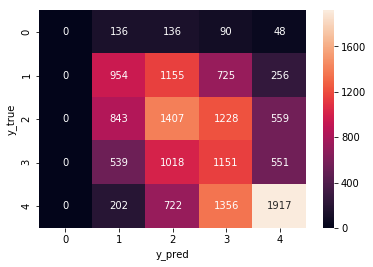

In [48]:
# params = {
#     'application': 'regression',
#     'boosting': 'gbdt',
#     'metric': 'rmse',
#     'num_leaves': 80,
#     'max_depth': 11,
#     'learning_rate': 0.01,
# #     'bagging_fraction': 0.9,
# #     'feature_fraction': 0.8,
# #     'min_split_gain': 0.01,
# #     'min_child_samples': 150,
# #     'min_child_weight': 0.1,
#     'verbosity': 1,
#     'early_stop': 100,
#     'verbose_eval': 100,
#     'num_rounds': 10000
# }

params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'max_bin': 512,
          'num_leaves': 30,
          'max_depth': 6,
          'min_data_in_leaf': 10,
          'learning_rate': 0.001,
#           'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_weight': 0.02,
          'lambda_l2': 0.2,
          'verbosity': 1,
          'early_stop': 500,
          'verbose_eval': 100,
          'num_rounds': 10000,
         }



# params = {'application': 'regression',
#           'boosting': 'gbdt',
#           'metric': 'rmse',
#           'num_leaves': 70,
#           'max_depth': 9,
#           'learning_rate': 0.01,
#           'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_samples': 150,
#           'min_child_weight': 0.02,
#           'lambda_l2': 0.0475,
#           'verbosity': -1,
#           'data_random_seed': 17}


results = run_cv_model(
    'lgbm', train_f, train_y, train_x['RescuerID'], test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: QwkOptimizer()
)

In [53]:
display(pd.DataFrame(
    Counter(dict(zip(f_names, results['models'][0].model.feature_importance('gain')))).most_common(100)
))

0              1
0                                   cat_cols_Breed1@c  515179.702916
1                                        num_cols_Age  391941.525415
2                               cat_cols_Sterilized@c  109767.612425
3                  rescuer_fs_Type_cat_col_features_2   52059.698224
4                                   cat_cols_Breed2@c   51125.398274
5            rescuer_fs_PhotoAmt_num_col_features_sum   47838.754436
6                                    cat_cols_State@c   45254.057627
7           rescuer_fs_Quantity_num_col_features_mean   40575.521587
8                rescuer_fs_Age_num_col_features_mean   39706.839125
9           rescuer_fs_PhotoAmt_num_col_features_mean   39523.141807
10           rescuer_fs_Sterilized_cat_col_features_2   35889.190979
11           rescuer_fs_PhotoAmt_num_col_features_std   33918.591371
12  rescuer_fs_doc_sent_magnitude_num_col_features...   32278.510279
13                                  num_cols_Quantity   29303.131022
14           rescuer_fs_Vaccinated_cat_col_features_3   22260.593412
15                                  num_cols_PhotoAmt   21714.770802
16  rescuer_fs_first_sentence_magnitude_num_col_fe...   20927.974398
17           rescuer_fs_Quantity_num_col_features_min   18410.154257
18          rescuer_fs_FurLength_num_col_features_sum   16474.175291
19           rescuer_fs_PhotoAmt_num_col_features_max   15226.563411
20          rescuer_fs_FurLength_num_col_features_std   14954.099413
21           rescuer_fs_PhotoAmt_num_col_features_min   14375.019211
22                             desc_tokenizing_svd_29   13388.705388
23               rescuer_fs_Gender_cat_col_features_1   13251.795547
24                             desc_tokenizing_nmf_99   12945.627378
25  rescuer_fs_first_sentence_magnitude_num_col_fe...   12670.196321
26             rescuer_fs_Breed1_cat_col_features_307   12266.682116
27                                  cat_cols_Gender@c   11025.462009
28                                  cat_cols_Color1@c   10307.823086
29  rescuer_fs_mean_sentence_magnitude_num_col_fea...   10051.890508
30               rescuer_fs_Color3_cat_col_features_4   10042.918868
31                              desc_tokenizing_svd_8   10012.902095
32  rescuer_fs_first_sentence_score_num_col_featur...    9895.345179
33  rescuer_fs_third_sentence_score_num_col_featur...    9521.162695
34                             desc_tokenizing_svd_54    9507.313196
35                              num_cols_MaturitySize    9415.810806
36                             desc_tokenizing_svd_79    9266.227711
37               rescuer_fs_Gender_cat_col_features_3    9114.219080
38                             desc_tokenizing_svd_17    8940.216492
39               rescuer_fs_Fee_num_col_features_mean    8414.058311
40                  desc_text_fs_desc_mean_token_size    8362.782991
41                             desc_tokenizing_nmf_76    8284.501591
42           rescuer_fs_Sterilized_cat_col_features_1    8262.080286
43       rescuer_fs_MaturitySize_num_col_features_std    7917.184302
44                                cat_cols_Dewormed@c    7826.565899
45     rescuer_fs_sentence_count_num_col_features_sum    7669.893396
46                            desc_tokenizing_svd_124    7655.269908
47  rescuer_fs_mean_sentence_score_num_col_feature...    7157.144203
48                             desc_tokenizing_nmf_98    7016.793711
49             rescuer_fs_Breed2_cat_col_features_266    7003.441095
50                rescuer_fs_Age_num_col_features_sum    6928.292597
51                             desc_tokenizing_svd_44    6848.120056
52                             desc_tokenizing_svd_96    6676.865117
53                            desc_tokenizing_svd_101    6628.887104
54                            desc_tokenizing_nmf_117    6604.222211
55                                 entity_sents_svd_3    6600.361499
56  rescuer_fs_std_sentence_score_num_col_features...    6553.349198
57                            desc_tokenizing_svd_

# of examples      0       1       2       3       4
fold 0: dev_y        79.96%  2.73%  20.61%  26.93%  21.74%  27.99%
fold 0: val_y        20.04%  2.76%  20.60%  26.92%  21.73%  27.99%

(11988, 336)
(3005, 336)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15841	valid_1's rmse: 1.16467
[200]	training's rmse: 1.14215	valid_1's rmse: 1.15379
[300]	training's rmse: 1.12768	valid_1's rmse: 1.14409
[400]	training's rmse: 1.11469	valid_1's rmse: 1.1354
[500]	training's rmse: 1.10309	valid_1's rmse: 1.12768
[600]	training's rmse: 1.0926	valid_1's rmse: 1.12136
[700]	training's rmse: 1.08307	valid_1's rmse: 1.11596
[800]	training's rmse: 1.07427	valid_1's rmse: 1.11119
[900]	training's rmse: 1.0662	valid_1's rmse: 1.10699
[1000]	training's rmse: 1.05874	valid_1's rmse: 1.10333
[1100]	training's rmse: 1.05184	valid_1's rmse: 1.0999
[1200]	training's rmse: 1.04546	valid_1's rmse: 1.09678
[1300]	training's rmse: 1.03941	valid_1's rmse: 1.09415
[1400]	training's rmse: 1.03351	valid_1's rmse: 1.09137
[1500]	training's rmse: 1.02794	valid_1's rmse: 1.08896
[1600]	training's rmse: 1.02252	valid_1's rmse: 1.08654
[1700]	training's rmse: 1.01

# of examples      0       1       2       3       4
fold 1: dev_y        80.03%  2.74%  20.61%  26.93%  21.74%  27.99%
fold 1: val_y        19.97%  2.71%  20.61%  26.92%  21.74%  28.02%

(11999, 336)
(2994, 336)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15802	valid_1's rmse: 1.16241
[200]	training's rmse: 1.14104	valid_1's rmse: 1.15063
[300]	training's rmse: 1.12607	valid_1's rmse: 1.14071
[400]	training's rmse: 1.11273	valid_1's rmse: 1.13305
[500]	training's rmse: 1.10095	valid_1's rmse: 1.12686
[600]	training's rmse: 1.09024	valid_1's rmse: 1.12142
[700]	training's rmse: 1.0804	valid_1's rmse: 1.11674
[800]	training's rmse: 1.07137	valid_1's rmse: 1.11245
[900]	training's rmse: 1.06309	valid_1's rmse: 1.10867
[1000]	training's rmse: 1.05546	valid_1's rmse: 1.10555
[1100]	training's rmse: 1.04836	valid_1's rmse: 1.10295
[1200]	training's rmse: 1.04165	valid_1's rmse: 1.10076
[1300]	training's rmse: 1.03516	valid_1's rmse: 1.09886
[1400]	training's rmse: 1.02906	valid_1's rmse: 1.09737
[1500]	training's rmse: 1.0233	valid_1's rmse: 1.09581
[1600]	training's rmse: 1.01767	valid_1's rmse: 1.09519
[1700]	training's rmse: 1.

# of examples      0       1       2       3       4
fold 2: dev_y        80.03%  2.74%  20.61%  26.93%  21.74%  27.99%
fold 2: val_y        19.97%  2.71%  20.61%  26.92%  21.74%  28.02%

(11999, 336)
(2994, 336)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15788	valid_1's rmse: 1.16158
[200]	training's rmse: 1.14125	valid_1's rmse: 1.14926
[300]	training's rmse: 1.12682	valid_1's rmse: 1.13885
[400]	training's rmse: 1.1137	valid_1's rmse: 1.12962
[500]	training's rmse: 1.10206	valid_1's rmse: 1.12115
[600]	training's rmse: 1.09151	valid_1's rmse: 1.11403
[700]	training's rmse: 1.08184	valid_1's rmse: 1.1082
[800]	training's rmse: 1.07294	valid_1's rmse: 1.10342
[900]	training's rmse: 1.06466	valid_1's rmse: 1.09891
[1000]	training's rmse: 1.05703	valid_1's rmse: 1.09516
[1100]	training's rmse: 1.04996	valid_1's rmse: 1.0918
[1200]	training's rmse: 1.04313	valid_1's rmse: 1.08886
[1300]	training's rmse: 1.03661	valid_1's rmse: 1.08614
[1400]	training's rmse: 1.03043	valid_1's rmse: 1.08368
[1500]	training's rmse: 1.02463	valid_1's rmse: 1.0815
[1600]	training's rmse: 1.01909	valid_1's rmse: 1.07974
[1700]	training's rmse: 1.01

# of examples      0       1       2       3       4
fold 3: dev_y        80.02%  2.73%  20.61%  26.92%  21.74%  28.00%
fold 3: val_y        19.98%  2.74%  20.63%  26.94%  21.73%  27.97%

(11997, 336)
(2996, 336)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15711	valid_1's rmse: 1.16275
[200]	training's rmse: 1.13999	valid_1's rmse: 1.15107
[300]	training's rmse: 1.12491	valid_1's rmse: 1.14139
[400]	training's rmse: 1.11164	valid_1's rmse: 1.13304
[500]	training's rmse: 1.09982	valid_1's rmse: 1.12582
[600]	training's rmse: 1.08917	valid_1's rmse: 1.12049
[700]	training's rmse: 1.07953	valid_1's rmse: 1.11559
[800]	training's rmse: 1.07042	valid_1's rmse: 1.11125
[900]	training's rmse: 1.06212	valid_1's rmse: 1.10771
[1000]	training's rmse: 1.05454	valid_1's rmse: 1.10473
[1100]	training's rmse: 1.04736	valid_1's rmse: 1.10203
[1200]	training's rmse: 1.04077	valid_1's rmse: 1.09973
[1300]	training's rmse: 1.03452	valid_1's rmse: 1.09793
[1400]	training's rmse: 1.02858	valid_1's rmse: 1.09591
[1500]	training's rmse: 1.02286	valid_1's rmse: 1.09414
[1600]	training's rmse: 1.01734	valid_1's rmse: 1.09257
[1700]	training's rmse: 

# of examples      0       1       2       3       4
fold 4: dev_y        79.96%  2.73%  20.61%  26.92%  21.74%  28.00%
fold 4: val_y        20.04%  2.76%  20.61%  26.93%  21.74%  27.96%

(11989, 336)
(3004, 336)
Training until validation scores don't improve for 2000 rounds.
[100]	training's rmse: 1.15705	valid_1's rmse: 1.16258
[200]	training's rmse: 1.13982	valid_1's rmse: 1.15104
[300]	training's rmse: 1.12482	valid_1's rmse: 1.14122
[400]	training's rmse: 1.1114	valid_1's rmse: 1.13265
[500]	training's rmse: 1.09935	valid_1's rmse: 1.12545
[600]	training's rmse: 1.08857	valid_1's rmse: 1.11934
[700]	training's rmse: 1.07882	valid_1's rmse: 1.11464
[800]	training's rmse: 1.0698	valid_1's rmse: 1.11056
[900]	training's rmse: 1.06163	valid_1's rmse: 1.107
[1000]	training's rmse: 1.05399	valid_1's rmse: 1.10388
[1100]	training's rmse: 1.04691	valid_1's rmse: 1.10101
[1200]	training's rmse: 1.04018	valid_1's rmse: 1.09824
[1300]	training's rmse: 1.03388	valid_1's rmse: 1.09629
[1400]	training's rmse: 1.02789	valid_1's rmse: 1.09468
[1500]	training's rmse: 1.02212	valid_1's rmse: 1.09339
[1600]	training's rmse: 1.01665	valid_1's rmse: 1.09268
[1700]	training's rmse: 1.01

dev cv rmse val cv rmse dev cv qwk val cv qwk
lgbm - fold 0       0.774       1.059      0.781      0.412
lgbm - fold 1       0.876       1.086      0.688      0.361
lgbm - fold 2       0.763       1.060      0.787      0.407
lgbm - fold 3       0.832       1.080      0.729      0.373
lgbm - fold 4       0.872       1.085      0.692      0.359

params dev cv rmse (avg) dev cv rmse (std) val cv rmse (avg)  \
lgbm                    0.823             0.047             1.074   

     val cv rmse (std) dev cv qwk (avg) dev cv qwk (std) val cv qwk (avg)  \
lgbm             0.012            0.735            0.042            0.383   

     val cv qwk (std) train set qwk  
lgbm            0.022         0.386

0       1       2       3       4
train_y       2.73%  20.61%  26.93%  21.74%  27.99%
pred_train_y  0.00%  17.49%  29.80%  30.71%  22.00%
pred_test_y   0.00%  19.20%  30.07%  29.36%  21.38%

Saving to path `predictions/lgbm-14.csv`


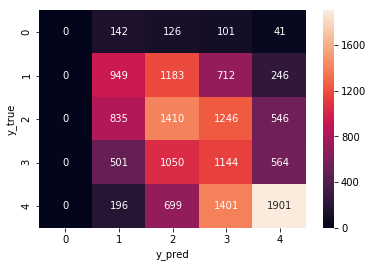

In [24]:
# params = {
#     'application': 'regression',
#     'boosting': 'gbdt',
#     'metric': 'rmse',
#     'num_leaves': 80,
#     'max_depth': 11,
#     'learning_rate': 0.01,
# #     'bagging_fraction': 0.9,
# #     'feature_fraction': 0.8,
# #     'min_split_gain': 0.01,
# #     'min_child_samples': 150,
# #     'min_child_weight': 0.1,
#     'verbosity': 1,
#     'early_stop': 100,
#     'verbose_eval': 100,
#     'num_rounds': 10000
# }

params = {'application': 'regression',
          'boosting': 'gbdt',
          'metric': 'rmse',
          'max_bin': 512,
          'num_leaves': 30,
          'max_depth': 6,
          'min_data_in_leaf': 10,
          'learning_rate': 0.001,
          'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_weight': 0.02,
          'lambda_l2': 0.25,
          'verbosity': 1,
          'early_stop': 2000,
          'verbose_eval': 100,
          'num_rounds': 20000,
         }


# params = {'application': 'regression',
#           'boosting': 'gbdt',
#           'metric': 'rmse',
#           'num_leaves': 70,
#           'max_depth': 9,
#           'learning_rate': 0.01,
#           'bagging_fraction': 0.85,
#           'feature_fraction': 0.8,
#           'min_split_gain': 0.02,
#           'min_child_samples': 150,
#           'min_child_weight': 0.02,
#           'lambda_l2': 0.0475,
#           'verbosity': -1,
#           'data_random_seed': 17}


run_cv_model(
    'lgbm', train_f, train_y, train_x['RescuerID'], test_f, test_ids, 
    lambda: LgbmPredictor(params, f_names), lambda: QwkOptimizer()
)

In [ ]:
train